# Teste técnico Cognitivo

<p>Nesse script iremos prever o preço da estadia<p>

In [1]:
#Bibliotecas básicas
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set(style="ticks", color_codes=True)
import numpy as np
from scipy import stats


In [2]:
#Bibliotecas par modelagem
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
#Importação dos dados
input = '/home/matheusgp/Documents/Projetos/Cognitivo/listings.csv'
df = pd.read_csv(input,sep=',')

## Análise Explotatória

Nessa parte procuramos identificar variáveis que não contribuam com o modelo e já possam ser retiradas. 
Além disso, nessa etapa faremos um estudo estatístico para ver o comportamento dos dados.


### Conhecendo o básico dos dados

> - Entendendimento das colunas;
> - Análise de estatística básica;
> - Verificação de correlações;
> - Retirada de colunas que não contribuem para o objetivo.


In [4]:
#Olhando uma parte dos dados
df.head()

id                                            name  host_id  \
0  17878               Very Nice 2Br - Copacabana - WiFi    68997   
1  25026       Beautiful Modern Decorated Studio in Copa   102840   
2  31560                NICE & COZY 1BDR - IPANEMA BEACH   135635   
3  35636                Cosy flat close to Ipanema beach   153232   
4  35764  COPACABANA SEA BREEZE  -  RIO - 20 X Superhost   153691   

                  host_name  neighbourhood_group neighbourhood  latitude  \
0                  Matthias                  NaN    Copacabana -22.96592   
1                   Viviane                  NaN    Copacabana -22.97712   
2                    Renata                  NaN       Ipanema -22.98302   
3                  Patricia                  NaN       Ipanema -22.98816   
4  Patricia Miranda & Paulo                  NaN    Copacabana -22.98127   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0  -43.17896  Entire home/apt    329               4                238   
1  -43.19045  Entire home/apt    158               7                233   
2  -43.21427  Entire home/apt    270               2                264   
3  -43.19359  Entire home/apt    374               2                162   
4  -43.19046  Entire home/apt    129               3                309   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2019-08-24               2.13                               1   
1  2019-08-03               2.06                               3   
2  2019-08-10               2.36                               1   
3  2019-09-09               2.25                               1   
4  2019-09-15               2.83                               1   

   availability_365  
0               312  
1               114  
2               137  
3                73  
4               118

In [5]:
#Verificando a quantidade de linhas e colunas do dataframe
df.shape

(34329, 16)

In [6]:
#Verificando informações sobre linhas nulas,tipos das variáveis, alocação de memória
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34329 entries, 0 to 34328
Data columns (total 16 columns):
id                                34329 non-null int64
name                              34265 non-null object
host_id                           34329 non-null int64
host_name                         34315 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     34329 non-null object
latitude                          34329 non-null float64
longitude                         34329 non-null float64
room_type                         34329 non-null object
price                             34329 non-null int64
minimum_nights                    34329 non-null int64
number_of_reviews                 34329 non-null int64
last_review                       18285 non-null object
reviews_per_month                 18285 non-null float64
calculated_host_listings_count    34329 non-null int64
availability_365                  34329 non-null int64
dt

In [7]:
#Retirando as colunas do tipo object e a coluna toda nula
df.drop(['id','name','host_id','host_name','neighbourhood_group','neighbourhood','latitude','longitude','last_review'],axis=1,inplace=True)

<p>Vamos analisar se existe valores nulos nos dados.<p>

In [8]:
df.isnull().sum()

room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 16044
calculated_host_listings_count        0
availability_365                      0
dtype: int64

<p>Observamos do resultado acima que temos 16044 valores nulos na coluna <strong>reviews_per_month</strong>.<p>
    <p>Vamos considerar os valores nulos como 0.<p>

In [9]:
#Substituimos os valores nulos por 0
df.fillna({'reviews_per_month':0},inplace=True)

In [10]:
df.dtypes

room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [11]:
#categorizando os dados
#Nessa técnica, usamos uma ordenação simples para arrumar os dados do room_type
df['room_encoder'] =LabelEncoder().fit_transform(df['room_type'])
df.drop('room_type',axis=1,inplace=True)

In [12]:
df.dtypes

price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
room_encoder                        int64
dtype: object

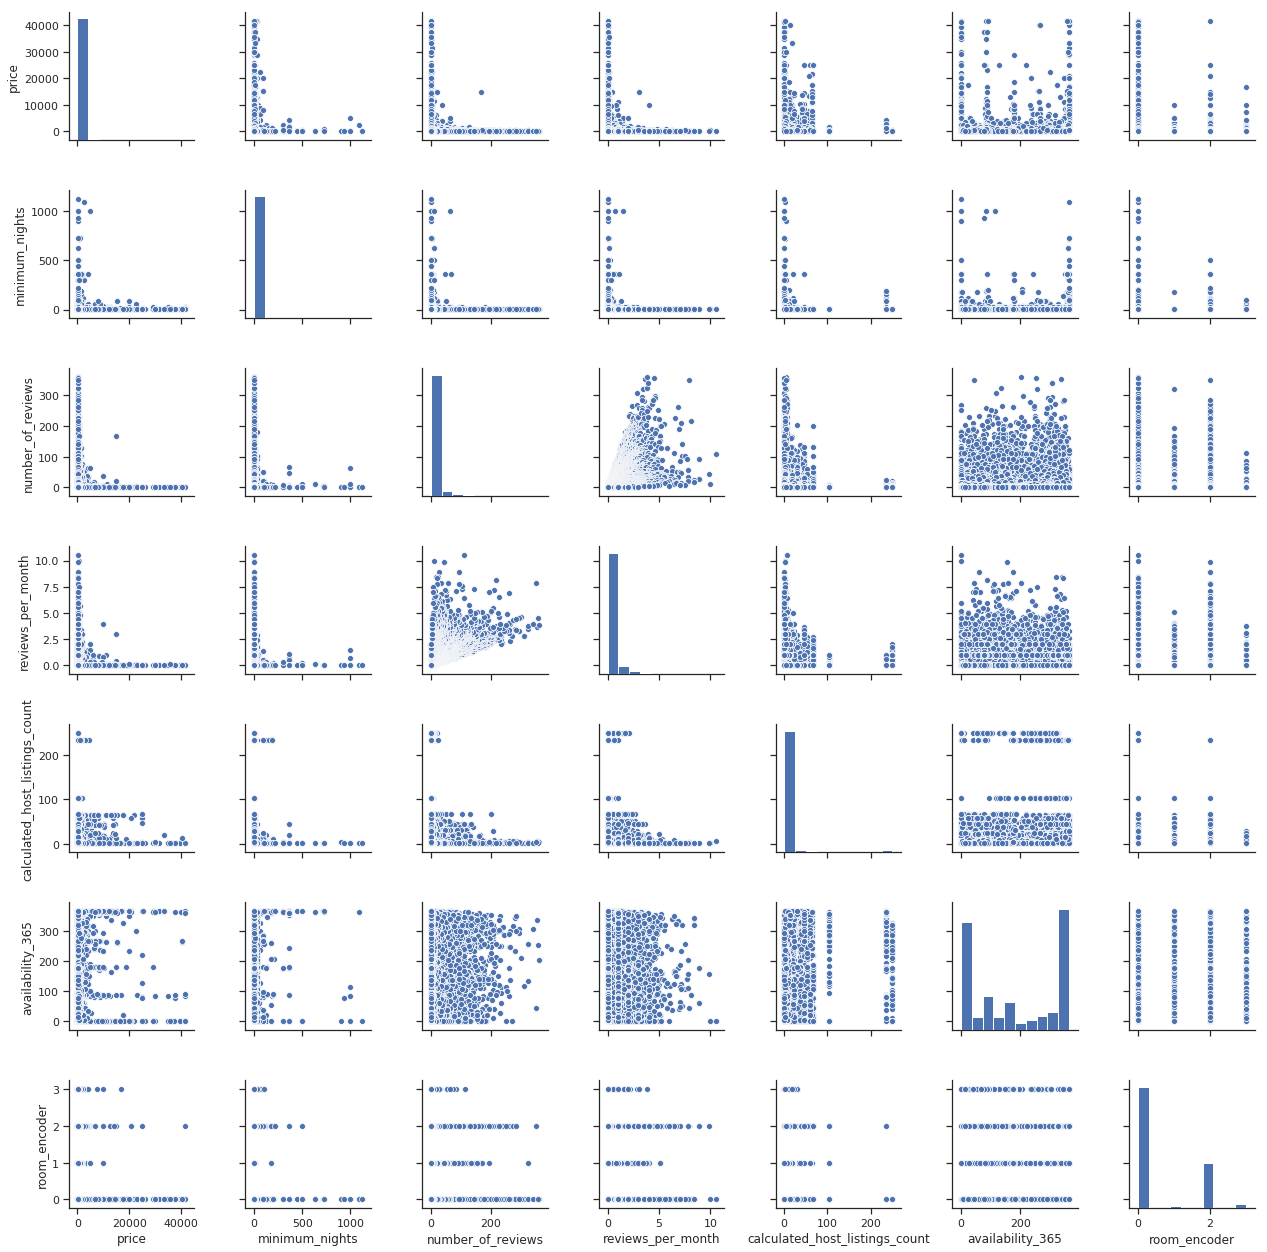

In [13]:
sns.pairplot(df)

<font size='4'><p>Análise da variável resposta.<p></font>

<p>Como buscamos prever o preço da estadia, e sabendo que preço é uma variável contínua, temos uma situação clássica de regressão.<p>
<p>Então, retiramos as variáveis que não fazem sentido para nosso problema, como <strong>id</strong>, <strong>name</strong>, <strong>host_id</strong>, <strong>host_name</strong>, <strong>latitude</strong>, <strong>longitude</strong>, <strong>neighbourhood</strong> e <strong>last_review</strong>.<p>
     <p>Além disso, observamos que a coluna <strong>neighbourhood_group</strong> está toda vazia. Portanto, iremos retira-lá também. <p> 

In [14]:
df.price.describe()

count    34329.000000
mean       647.950683
std       1694.920776
min          0.000000
25%        150.000000
50%        290.000000
75%        601.000000
max      41592.000000
Name: price, dtype: float64

In [15]:
#Observando distribuição dos valores da variável price
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 41592), vert=False, flierprops=red_square, figsize=(20,2));

(array([3.4132e+04, 1.2400e+02, 2.9000e+01, 1.7000e+01, 2.7000e+01]),
 array([    0. ,  8318.4, 16636.8, 24955.2, 33273.6, 41592. ]),
 <a list of 5 Patch objects>)

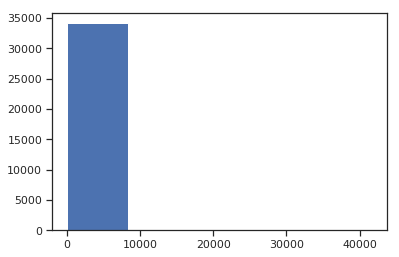

In [16]:
plt.hist(df.price,bins=5)

In [17]:
#Não faz sentido preço 0
df.drop(df[ df.price == 0 ].index, axis=0, inplace=True)

In [18]:
#análise de outlier simples usando distância interquartílica
q1 = np.percentile(df.price,25)
q3 = np.percentile(df.price,75)
iqr = q3-q1
upper = q3 + iqr*1.5
lower = q3 - iqr*1.5
df = df[(df['price']<upper) & (df['price']>lower)]

In [19]:
upper

1277.5

In [20]:
df.price.describe()

count    30996.000000
mean       352.652665
std        288.788639
min         17.000000
25%        149.000000
50%        250.000000
75%        487.000000
max       1277.000000
Name: price, dtype: float64

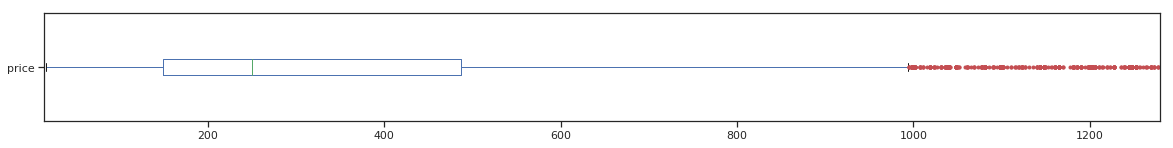

In [21]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(15, 1280), vert=False, flierprops=red_square, figsize=(20,2));

<p>Antes, vamos separar os dados para teste e treino.<p>

In [22]:
X = df.drop('price',axis=1)
Y = df.price

In [23]:
minmax = MinMaxScaler(feature_range = (0,1))
X_norm = minmax.fit_transform(X)


/home/matheusgp/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


<p>Vamos aplicar a técnica de <strong>XGBRegressor</strong> nos dados<p>

In [24]:
model = XGBRegressor(n_estimators=250,max_depth=7,learning_rate=0.01)

In [25]:
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold) 




[23:32:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:32:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

In [26]:
print("Results: %.2f MSE: (%.2f)" % (results.mean(), results.std()))


Results: 0.24 MSE: (0.07)
